<a href="https://colab.research.google.com/github/hungry4089/--1/blob/main/205655_%ED%99%A9%EC%8A%B9%ED%98%84_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fredapi yfinance
!pip install koreanize-matplotlib  #한글설치

In [ ]:
from fredapi import Fred
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

yfinance: 주식시장 데이터, fred:경제지표

In [ ]:
# Fred의 API 키 설정
fred_api_key = 'd9db96539a91002a3b5033bbe47941a6'

#객체생성
fred = Fred(api_key=fred_api_key)

# 시작 및 종료 날짜 설정
start_date = '2010-01-01'
end_date = '2024-05-01'

yfinance API

In [ ]:
sp500 = yf.Ticker('^GSPC')           # S&P 500 지수 데이터 가져오기
sp500_data = sp500.history(start=start_date, end=end_date)
sp500_data.index = sp500_data.index.date

nvda = yf.Ticker('NVDA')             # 엔비디아 주식 데이터 가져오기
nvda_data = nvda.history(start=start_date, end=end_date)
nvda_data.index = nvda_data.index.date

exchange_rate = yf.Ticker('KRW=X')   # 환율 정보 가져오기 (USD/KRW)
exchange_rate_data = exchange_rate.history(start=start_date, end=end_date)
exchange_rate_data.index = exchange_rate_data.index.date

# 전체 날짜 범위 생성
full_date_range = pd.date_range(start=start_date, end=end_date)

# 데이터프레임의 인덱스를 동일한 날짜 범위로 재색인
sp500_data = sp500_data.reindex(full_date_range)
nvda_data = nvda_data.reindex(full_date_range)
exchange_rate_data = exchange_rate_data.reindex(full_date_range)

yf_data=pd.concat([nvda_data, sp500_data, exchange_rate_data], axis=1)
yf_data.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open,High,Low,...,Volume,Dividends,Stock Splits,Open,High,Low,Close,Volume,Dividends,Stock Splits
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1151.099976,1151.099976,1145.099976,1146.000000,0.0,0.0,0.0
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,4.244816,4.270042,4.153086,4.240230,80020400.0,0.0,0.0,1116.560059,1133.869995,1116.560059,...,3.991400e+09,0.0,0.0,1152.099976,1156.300049,1132.400024,1132.400024,0.0,0.0,0.0
2010-01-05,4.224178,4.348013,4.224178,4.302148,72864800.0,0.0,0.0,1132.660034,1136.630005,1129.660034,...,2.491020e+09,0.0,0.0,1132.300049,1142.300049,1128.900024,1141.300049,0.0,0.0,0.0


In [ ]:
yf_data = yf_data.iloc[:, [3, 4, 10, 17]] #필요한 데이터 추출

#열머리글 재설정
yf_data.columns=['nvda_가격','nvda_거래량','SP500_가격','환율']
yf_data

,nvda_가격,nvda_거래량,SP500_가격,환율
2010-01-01,NaN,NaN,NaN,1146.000000
2010-01-02,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN
2010-01-04,4.240230,80020400.0,1132.989990,1132.400024
2010-01-05,4.302148,72864800.0,1136.520020,1141.300049
...,...,...,...,...
2024-04-27,NaN,NaN,NaN,NaN
2024-04-28,NaN,NaN,NaN,NaN
2024-04-29,877.570007,38897100.0,5116.169922,1377.089966
2024-04-30,864.020020,36370900.0,5035.689941,1374.640015


fred API

In [ ]:
fedfunds_data = fred.get_series('FEDFUNDS')  # 미국 중앙은행의 기준금리 데이터 불러오기
fedfunds_data=fedfunds_data[fedfunds_data.index >= start_date]
fedfunds_data=fedfunds_data[fedfunds_data.index <= end_date]

gs10_data = fred.get_series('GS10')          # 미국 국채 금리 데이터 불러오기 (10년물 국채 금리)
gs10_data=gs10_data[gs10_data.index >= start_date]
gs10_data=gs10_data[gs10_data.index <= end_date]

gdp_data = fred.get_series('GDP')            # 미국의 GDP 데이터 불러오기
gdp_data=gdp_data[gdp_data.index >= start_date]
gdp_data=gdp_data[gdp_data.index <= end_date]

nasdaq_data = fred.get_series('NASDAQCOM')   # 나스닥 지수 데이터 불러오기
nasdaq_data=nasdaq_data[nasdaq_data.index >= start_date]
nasdaq_data=nasdaq_data[nasdaq_data.index <= end_date]

unemployment_data = fred.get_series('UNRATE')#미국의 실업률 데이터 불러오기
unemployment_data=unemployment_data[unemployment_data.index >= start_date]
unemployment_data=unemployment_data[unemployment_data.index <= end_date]

#데이터를 pandas 데이터프레임으로 변환
fedfunds_data = pd.DataFrame(fedfunds_data, columns=['기준금리'])
gs10_data = pd.DataFrame(gs10_data, columns=['국채금리'])
gdp_data = pd.DataFrame(gdp_data, columns=['GDP'])
nasdaq_data = pd.DataFrame(nasdaq_data, columns=['나스닥'])
unemployment_data = pd.DataFrame(unemployment_data, columns=['실업률'])

# 데이터프레임의 인덱스를 동일한 날짜 범위로 재색인
fedfunds_data = fedfunds_data.reindex(full_date_range)
gs10_data = gs10_data.reindex(full_date_range)
gdp_data = gdp_data.reindex(full_date_range)
nasdaq_data = nasdaq_data.reindex(full_date_range)
unemployment_data = unemployment_data.reindex(full_date_range)

fred_data=pd.concat([fedfunds_data, gs10_data, gdp_data, nasdaq_data, unemployment_data], axis=1)
fred_data

,기준금리,국채금리,GDP,나스닥,실업률
2010-01-01,0.11,3.73,14764.61,NaN,9.8
2010-01-02,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,2308.42,NaN
2010-01-05,NaN,NaN,NaN,2308.71,NaN
...,...,...,...,...,...
2024-04-27,NaN,NaN,NaN,NaN,NaN
2024-04-28,NaN,NaN,NaN,NaN,NaN
2024-04-29,NaN,NaN,NaN,15983.08,NaN
2024-04-30,NaN,NaN,NaN,15657.82,NaN


최종 데이터

In [ ]:
data=pd.concat([yf_data, fred_data], axis=1)
data = data.dropna(how='all') #값이 하나도 없는 행 제거
data

,nvda_가격,nvda_거래량,SP500_가격,환율,기준금리,국채금리,GDP,나스닥,실업률
2010-01-01,NaN,NaN,NaN,1146.000000,0.11,3.73,14764.61,NaN,9.8
2010-01-04,4.240230,80020400.0,1132.989990,1132.400024,NaN,NaN,NaN,2308.42,NaN
2010-01-05,4.302148,72864800.0,1136.520020,1141.300049,NaN,NaN,NaN,2308.71,NaN
2010-01-06,4.329666,64916800.0,1137.140015,1130.400024,NaN,NaN,NaN,2301.09,NaN
2010-01-07,4.244816,54779200.0,1141.689941,1134.900024,NaN,NaN,NaN,2300.05,NaN
...,...,...,...,...,...,...,...,...,...
2024-04-25,826.320007,42464100.0,5048.419922,1376.969971,NaN,NaN,NaN,15611.76,NaN
2024-04-26,877.349976,55101100.0,5099.959961,1371.699951,NaN,NaN,NaN,15927.90,NaN
2024-04-29,877.570007,38897100.0,5116.169922,1377.089966,NaN,NaN,NaN,15983.08,NaN
2024-04-30,864.020020,36370900.0,5035.689941,1374.640015,NaN,NaN,NaN,15657.82,NaN


속성별로 결측치 갯수 확인

In [ ]:
data.isnull().sum().sort_values(ascending=False)

GDP         3729
기준금리        3614
국채금리        3614
실업률         3614
nvda_가격      181
nvda_거래량     181
SP500_가격     181
나스닥          179
환율            54
dtype: int64

결측치 처리(선형 보간 수행:두 값 사이에 직선을 이용하여 그 사이의 값을 추정하는 방법)

In [ ]:
data = data.interpolate(method='linear')
data = data.dropna(how='any') #값이 하나라도 없는 행 제거
data

,nvda_가격,nvda_거래량,SP500_가격,환율,기준금리,국채금리,GDP,나스닥,실업률
2010-01-04,4.240230,80020400.0,1132.989990,1132.400024,0.110952,3.728095,14767.978484,2308.42,9.8
2010-01-05,4.302148,72864800.0,1136.520020,1141.300049,0.111905,3.726190,14771.346969,2308.71,9.8
2010-01-06,4.329666,64916800.0,1137.140015,1130.400024,0.112857,3.724286,14774.715453,2301.09,9.8
2010-01-07,4.244816,54779200.0,1141.689941,1134.900024,0.113810,3.722381,14778.083937,2300.05,9.8
2010-01-08,4.253987,47816800.0,1144.979980,1123.099976,0.114762,3.720476,14781.452422,2317.17,9.8
...,...,...,...,...,...,...,...,...,...
2024-04-25,826.320007,42464100.0,5048.419922,1376.969971,5.330000,4.540000,28284.498000,15611.76,3.9
2024-04-26,877.349976,55101100.0,5099.959961,1371.699951,5.330000,4.540000,28284.498000,15927.90,3.9
2024-04-29,877.570007,38897100.0,5116.169922,1377.089966,5.330000,4.540000,28284.498000,15983.08,3.9
2024-04-30,864.020020,36370900.0,5035.689941,1374.640015,5.330000,4.540000,28284.498000,15657.82,3.9


각 정보별 특징을 더 자세히 출력

In [ ]:
data.describe()

,nvda_가격,nvda_거래량,SP500_가격,환율,기준금리,국채금리,GDP,나스닥,실업률
count,3785.000000,3.785000e+03,3785.000000,3785.000000,3785.000000,3785.000000,3785.000000,3785.000000,3785.000000
mean,88.519440,5.035947e+07,2592.864082,1156.253576,1.066577,2.422988,20192.153018,7145.707062,5.854425
std,150.562343,3.078825e+07,1122.129109,81.137543,1.548628,0.871788,3839.930499,4131.505578,2.217077
min,2.036411,4.564400e+06,1022.580017,999.830017,0.050000,0.620000,14767.978484,2091.790000,3.400000
25%,3.978798,3.088800e+07,1666.290039,1106.619995,0.091818,1.811364,17042.711507,3606.120000,3.852174
50%,25.911039,4.337720e+07,2347.219971,1134.939941,0.180000,2.318696,19385.790000,5836.160000,5.054545
75%,124.567001,6.117680e+07,3398.959961,1187.979980,1.552609,2.900000,22013.252388,10782.820000,7.663636
max,950.020020,3.692928e+08,5254.350098,1443.959961,5.330000,4.800000,28284.498000,16442.200000,14.800000


각 항목이 어느 정도의 상관 관계를 가지고 있는지 그래프로 표현

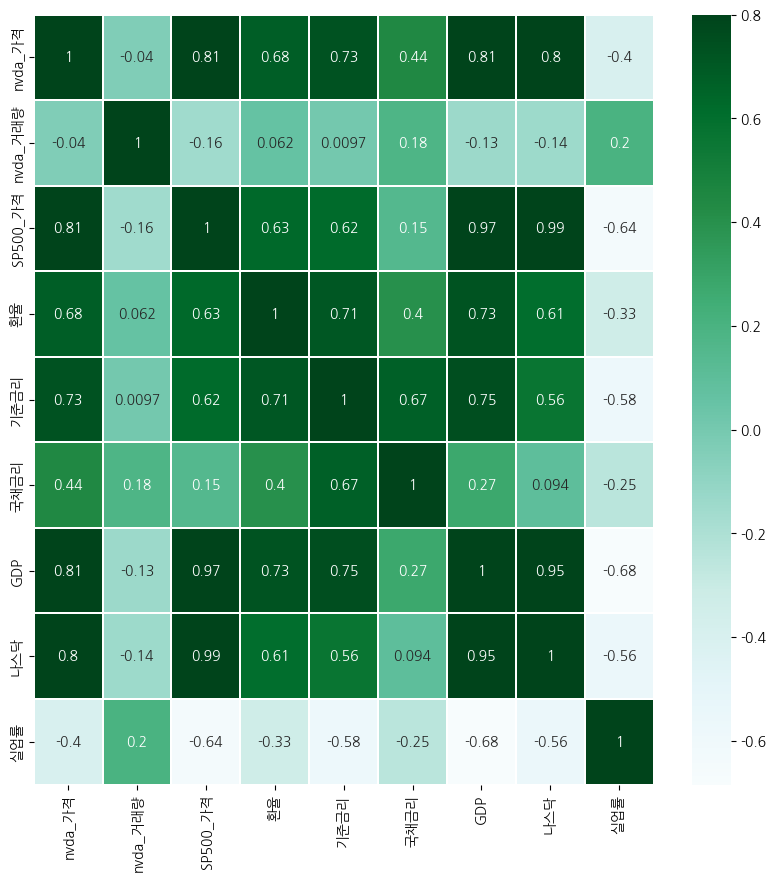

In [ ]:
plt.figure(figsize=(10,10)) #그래프 크기 지정
sns.heatmap(data.corr(),linewidths=0.1,vmax=0.8, cmap=plt.cm.BuGn, linecolor='white', annot=True)
plt.show()  #화면에 출력

예측할 엔비디아 가격과 관련이 큰 것부터 내림차순으로 저장

In [ ]:
data_imp=data.corr().sort_values('nvda_가격', ascending=False)
data_imp['nvda_가격']  #nvda_가격와 관련도 출력

nvda_가격     1.000000
GDP         0.808816
SP500_가격    0.805554
나스닥         0.800434
기준금리        0.731082
환율          0.681655
국채금리        0.442383
nvda_거래량   -0.039606
실업률        -0.399288
Name: nvda_가격, dtype: float64

엔비디아 가격과 관련도가 0보다 높은 속성(GDP, SP500가격, 나스닥, 기준금리, 환율, 국채금리)들을 추출한 상관도 그래프

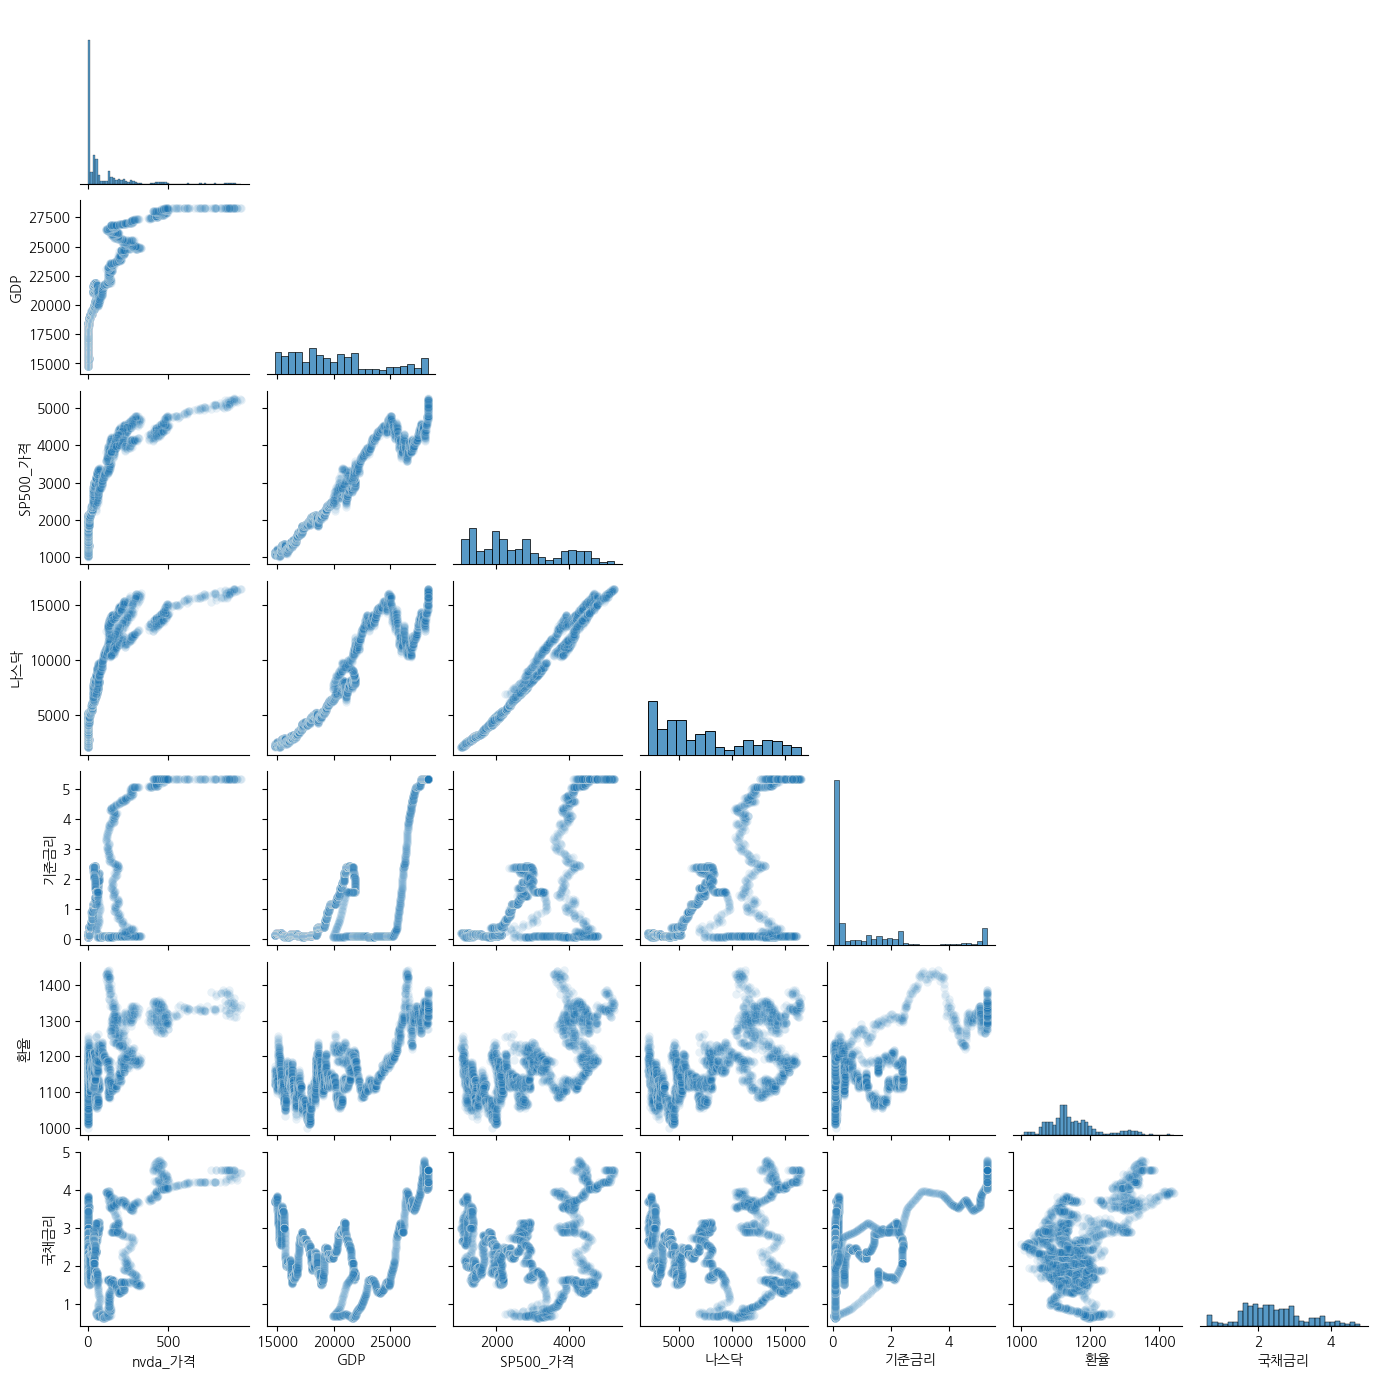

In [ ]:
sns.pairplot(data[['nvda_가격','GDP','SP500_가격','나스닥','기준금리','환율','국채금리']],\
             corner=True, height=2, plot_kws={'alpha':0.1})   #corner대각선 기준한쪽만 남김, height-크기, alpha-투명도(겹치는 부분 확인)
plt.show()

In [ ]:
x_data=data[['GDP','SP500_가격','나스닥','기준금리','환율','국채금리']] #nvda_가격을 제외한 나머지값 저장
y_data = data['nvda_가격'].values #배열로 nvda_가격 저장
x_data

,GDP,SP500_가격,나스닥,기준금리,환율,국채금리
2010-01-04,14767.978484,1132.989990,2308.42,0.110952,1132.400024,3.728095
2010-01-05,14771.346969,1136.520020,2308.71,0.111905,1141.300049,3.726190
2010-01-06,14774.715453,1137.140015,2301.09,0.112857,1130.400024,3.724286
2010-01-07,14778.083937,1141.689941,2300.05,0.113810,1134.900024,3.722381
2010-01-08,14781.452422,1144.979980,2317.17,0.114762,1123.099976,3.720476
...,...,...,...,...,...,...
2024-04-25,28284.498000,5048.419922,15611.76,5.330000,1376.969971,4.540000
2024-04-26,28284.498000,5099.959961,15927.90,5.330000,1371.699951,4.540000
2024-04-29,28284.498000,5116.169922,15983.08,5.330000,1377.089966,4.540000
2024-04-30,28284.498000,5035.689941,15657.82,5.330000,1374.640015,4.540000


데이터 전처리(정규화)

In [ ]:
scaler = MinMaxScaler() # 데이터를 최소값과 최대값을 기준으로 0과 1사이의 값으로 변환
X_scaled = scaler.fit_transform(x_data) # 입력데이터를 MinMaxScaler으로 스케일링
X_scaled

array([[0.00000000e+00, 2.60907306e-02, 1.50957359e-02, 1.15440115e-02,
        2.98493739e-01, 7.43563454e-01],
       [2.49212408e-04, 2.69249038e-02, 1.51159444e-02, 1.17243867e-02,
        3.18532974e-01, 7.43107769e-01],
       [4.98424816e-04, 2.70714135e-02, 1.45849491e-02, 1.19047619e-02,
        2.93990552e-01, 7.42652085e-01],
       ...,
       [1.00000000e+00, 9.67346956e-01, 9.68006489e-01, 1.00000000e+00,
        8.49435968e-01, 9.37799043e-01],
       [1.00000000e+00, 9.48328914e-01, 9.45340935e-01, 1.00000000e+00,
        8.43919674e-01, 9.37799043e-01],
       [1.00000000e+00, 9.48328914e-01, 9.41693652e-01, 1.00000000e+00,
        8.43919674e-01, 9.37799043e-01]])

전체의 95%를 학습셋으로, 5%를 테스트셋으로 지정

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.05)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3595, 6) (3595,) (190, 6) (190,)


모델 구조 생성

In [ ]:
model = Sequential()                                                #Sequential: 층(layer)을 순차적으로 쌓아서 신경망 모델을 만드는 방식
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu')) #노드(은닉층)의 수:64개, 입력층:입력 데이터 열의 수(5개), 활성화 함수-relu
model.add(Dense(32, activation='relu'))                             #노드(은닉층)의 수:32개, relu:0보다 크면 그대로, 0이하일땐 0, 출력 범위: (0, ∞)
model.add(Dense(16, activation='relu'))                             #노드(은닉층)의 수:16개
model.add(Dense(1))                                                 #출력층:학습에 대한 예측값
model.summary()                                                     #모델의 각 층(layer)에 대한 정보를 요약

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                448       
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3073 (12.00 KB)
Trainable params: 3073 (12.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


모델 실행

In [ ]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)      #val_loss가 50번 이상 좋아지지 않는다면 조기종료(과적합 방지)
checkpoint = ModelCheckpoint(filepath="saved_models", monitor='val_loss', verbose=1, save_best_only=True)#학습 과정 중 가장 좋은 성능의 모델을 저장

# 모델 훈련
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=32, callbacks=[early_stopping_callback, checkpoint])

Epoch 1/1000
66/79 [========================>.....] - ETA: 0s - loss: 423011.8750
Epoch 1: val_loss improved from inf to 13155.52832, saving model to saved_models
79/79 [==============================] - 2s 15ms/step - loss: 356460.6875 - val_loss: 13155.5283
Epoch 2/1000
78/79 [============================>.] - ETA: 0s - loss: 9265.0420
Epoch 2: val_loss improved from 13155.52832 to 9900.86035, saving model to saved_models
79/79 [==============================] - 1s 18ms/step - loss: 9210.8330 - val_loss: 9900.8604
Epoch 3/1000
66/79 [========================>.....] - ETA: 0s - loss: 7753.1123
Epoch 3: val_loss did not improve from 9900.86035
79/79 [==============================] - 0s 5ms/step - loss: 7903.5054 - val_loss: 10731.3828
Epoch 4/1000
74/79 [===========================>..] - ETA: 0s - loss: 6981.8394
Epoch 4: val_loss improved from 9900.86035 to 7691.84473, saving model to saved_models
79/79 [==============================] - 1s 17ms/step - loss: 6845.9150 - val_loss: 769

손실값 시각화

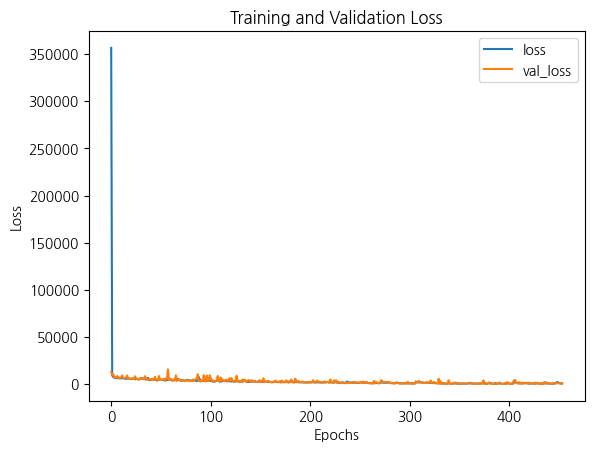

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

지금까지 학습한 모델로 검증 데이터에 대한 예측 수행

6/6 [==============================] - 0s 2ms/step


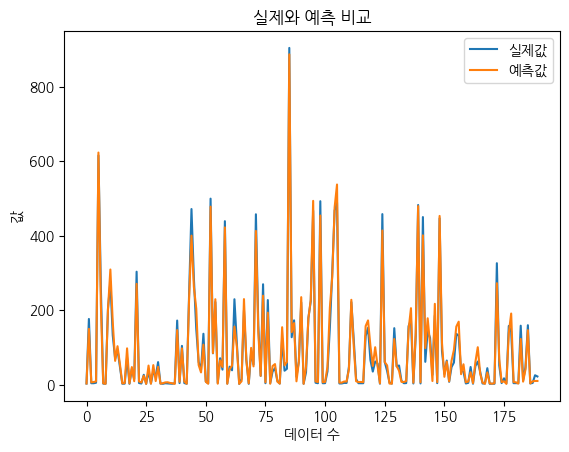

In [ ]:
prediction=model.predict(X_test)
plt.plot(y_test, label='실제값')
plt.plot(prediction, label='예측값')
plt.title('실제와 예측 비교')
plt.xlabel('데이터 수')
plt.ylabel('값')
plt.legend()
plt.show()

데이터가 너무 많으니 마지막 부분 값만 출력

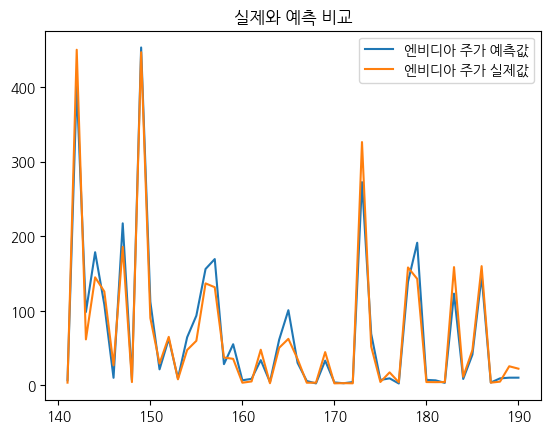

In [ ]:
real_prices =[]   #실제 값 리스트 생성
pred_prices = []  #예측 값 리스트 생성
X_num = []        #실행 번호 리스트 생성
repet=50          #출력 갯수 설정
num = len(y_test)-repet

for i in range(repet):                                  #반복문
    real = y_test[len(y_test)-repet+i]                  #실제 결과값 리스트에서 값 호출
    predictions = prediction[len(y_test)-repet+i]       #예측 결과값 리스트에서 값 호출
    real_prices.append(real)                            #real 값을 real_prices 리스트에 추가
    pred_prices.append(predictions)                      #prediction값을 pred_prices 리스트에 추가
    num = num + 1
    X_num.append(num)

# 그래프를 통해 샘플로 뽑은 50개의 값을 비교
plt.plot(X_num, pred_prices, label='엔비디아 주가 예측값')   #주어진 데이터 시퀀스를 사용하여 선 그래프 출력.(x축, y축, 제목)
plt.plot(X_num, real_prices, label='엔비디아 주가 실제값')
plt.title('실제와 예측 비교')
plt.legend()
plt.show()